In [180]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, classification_report, log_loss, precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings("ignore")

In [116]:
df=pd.read_csv('bank-loan-project/loan.csv')

In [117]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Interest.Rate,2497.0,13.067521,4.180074,5.42,10.16,13.11,15.8,24.89
FICO.Score,2499.0,705.870348,35.029051,640.00,680.00,700.00,725.0,830.00
Loan.Length,2500.0,41.260800,9.930893,36.00,36.00,36.00,36.0,60.00
Monthly.Income,2495.0,5690.259599,3964.704795,588.50,3500.00,5000.00,6800.0,102750.00
Loan.Amount,2500.0,12406.500000,7801.544872,1000.00,6000.00,10000.00,17000.0,35000.00


In [118]:
#small number of missing values, decision made to eliminate these
df.dropna(how='any', inplace=True) 

In [122]:
#assess data by reviewing correlations
df.corr()
#interest rate and FICO score have a strong negative correlation, which is expected
#interest rate and loan lenth have a positive correlation, which is expected
#interest rate and monthly income correlation is nearly 0, would expect this to be more in the positive direction
#interest rate and loan amount have a positive correlation, which is expected

,Interest.Rate,FICO.Score,Loan.Length,Monthly.Income,Loan.Amount
Interest.Rate,1.000000,-0.708646,0.424041,0.013218,0.332411
FICO.Score,-0.708646,1.000000,0.012850,0.121372,0.083618
Loan.Length,0.424041,0.012850,1.000000,0.073693,0.412133
Monthly.Income,0.013218,0.121372,0.073693,1.000000,0.389300
Loan.Amount,0.332411,0.083618,0.412133,0.389300,1.000000


In [123]:
#dichotomize interest rate as low (<= 9) vs > high (> 9)
df['Interest.Rate.lt'] = np.where(df['Interest.Rate'] <= 9, 1, 0)

In [124]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Interest.Rate,2492.0,13.073146,4.175694,5.42,10.16,13.11,15.8,24.89
FICO.Score,2492.0,705.850722,34.977750,640.00,680.00,700.00,725.0,830.00
Loan.Length,2492.0,41.277689,9.942344,36.00,36.00,36.00,36.0,60.00
Monthly.Income,2492.0,5691.391533,3966.859450,588.50,3500.00,5000.00,6800.0,102750.00
Loan.Amount,2492.0,12419.652889,7807.860296,1000.00,6000.00,10000.00,17000.0,35000.00
Interest.Rate.lt,2492.0,0.213884,0.410128,0.00,0.00,0.00,0.0,1.00


In [134]:
#include FICO score, loan length, monthly income and loan amount as continuous 
#predictors of low interest rate (<=9%)
X = df.drop(columns=['Interest.Rate', 'Interest.Rate.lt'])
y = df['Interest.Rate.lt']

In [ ]:
#split and scale

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=21)
# If not scaling ...
# Convergence Warning: The max_iter was reached which means the coef_ did not converge
scalar = StandardScaler().fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

In [136]:
#Gridsearch to find the best model

In [137]:
params = {
          'penalty': ['l2'], 
          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'fit_intercept': [True, False],
          'C': np.logspace(-3,3)
         }
gs = GridSearchCV(LogisticRegression(), param_grid=params, scoring='neg_log_loss', cv=10, n_jobs=5).fit(X_train, y_train)
gs

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=5,
       param_grid={'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'fit_intercept': [True, False], 'C': array([1.00000e-03, 1.32571e-03, 1.75751e-03, 2.32995e-03, 3.08884e-03,
       4.09492e-03, 5.42868e-03, 7.19686e-03, 9.54095e-03, 1.26486e-02,
       1.67683e-02, 2.2230... 1.84207e+02, 2.44205e+02,
       3.23746e+02, 4.29193e+02, 5.68987e+02, 7.54312e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [138]:
#Results

In [139]:
gs.best_estimator_

LogisticRegression(C=0.868511373751352, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [140]:
#Final Model

In [141]:
gs.best_params_

{'C': 0.868511373751352,
 'fit_intercept': True,
 'penalty': 'l2',
 'solver': 'saga'}

In [169]:
#using best parameters from GS on training data
#B0, B1, B2, B3, B4
#y intercept, FICO score, loan length, monthly income and loan amount as continuous 
model = LogisticRegression(**gs.best_params_).fit(X_train, y_train)

print(model.intercept_, model.coef_)

[-2.87019152] [[ 2.53720168 -1.51175367  0.23229486 -0.87264804]]


In [142]:
#calculate predicted probabilities using test data
y_hat = model.predict(X_test)
p_hat = model.predict_proba(X_test)[:,1]

In [143]:
#perfect model has log loss of 0
#log loss will increase as the predicted probability diverges from the true classification
#log loss seems pretty good
log_loss(y_test, p_hat)

0.2375928828939561

In [144]:
#baseline model achieves 0.77 accuracy, so we have improved accuracy with the proposed model 
baseline = 1 - (y_test.sum() / y_test.size)
accuracy = accuracy_score(y_test, y_hat)
baseline, accuracy

(0.7679222357229647, 0.8918590522478737)

In [145]:
# TP / (TP + FP) # type 1 errors
# % of true positives out of all positives (i.e. low interest rate)
precision_score(y_test, y_hat)

0.81875

In [146]:
# TP / (TP + FN) # type 2 errors
# % of true positives out of all results classified as positive
recall_score(y_test, y_hat)

0.6858638743455497

In [147]:
#model is able to discriminate low interest vs hight interest based on predictors
auc = roc_auc_score(y_test, p_hat)
auc

0.9536665783020744

In [ ]:
fpr, tpr, thr = roc_curve(y_test, p_hat)
for th, fp, tp in zip(thr, fpr, tpr):
    print("{0:.2f} {1:.2f} {2:.2f}".format(th, fp, tp))

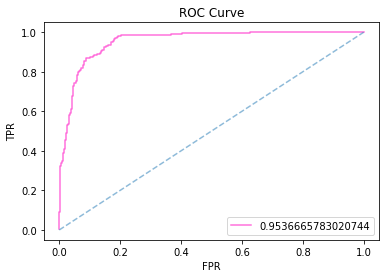

In [152]:
plt.plot(fpr, tpr, label=auc, color='#ff33cc', alpha=0.7)
plt.plot(np.linspace(0,1), np.linspace(0,1), linestyle='--', alpha=0.5)
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

Average precision-recall score: 0.63


Text(0.5,1,'2-class Precision-Recall curve: AP=0.63')

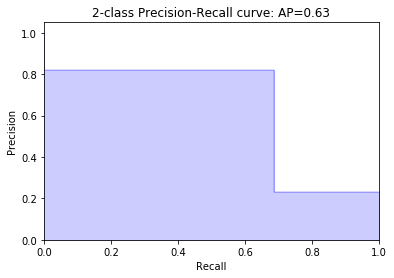

In [182]:
#precision-recall curve shows the tradeoff between precision and recall for different threshold
#high area under the curve represents both high recall and high precision
#high precision -> low false positive rate, and high recall -> low false negative rate

average_precision = average_precision_score(y_test, y_hat)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_test, y_hat)

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [163]:
y_hat.shape

(823,)

In [171]:
y_test.shape

(823,)

In [173]:
#compare test data (low interest rate) to predicted classification
y_test == y_hat
cm = confusion_matrix(y_test, y_hat)

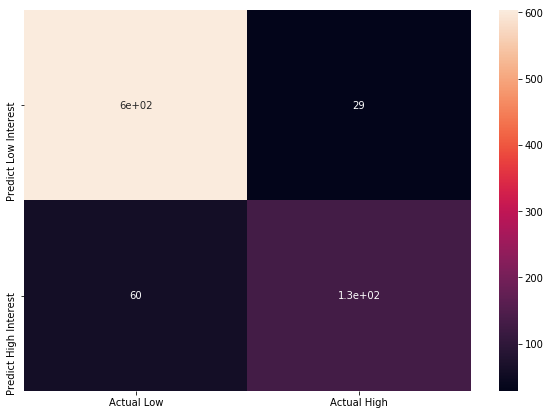

In [175]:
#wish to avoid false positives so as to not give low interest rate to folks that shouldnt qualify for low interest rate
cmdf = pd.DataFrame(cm, index=['Predicted Low Interest','Predicted High Interest'], columns=['Actual Low', 'Actual High'])

#plot confusion matrix:
plt.figure(figsize = (10,7))
sn.heatmap(cmdf, annot=True)
plt.show()

In [ ]:
#FICO score, loan length, monthly income and loan amount seem to do a nice job of predicting a
#low interest rate vs high interest rate